# Телеком 

## Задача проекта 

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

#### Данные

[final_provider.zip](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/ac39c23b-718e-4cd6-bdaa-85b3a127a457/final_provider.zip)

Данные также находятся в тренажёре, в папке `/datasets/final_provider/`.

### Цель проекта
- научиться прогнозировать отток клиентов
- построить модель с предельно большим значением метрики AUC-ROC.
- проверить модель на тестовой выборке, довести метрику до значения не ниже 0.88

### Этапы работы:

1. План работ (сам план в конце этого ноутбука)

2. Анализ и моделирование

3. Подготовка отчета


**Описание полей данных**
- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип договора: ежемесячный, годовой и т.д,
- PaperlessBilling – факт выставления счёта на электронную почту,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги,
- TotalCharges – всего потрачено денег на услуги,
- Dependents – наличие иждивенцев,
- Senior Citizen – наличие пенсионного статуса по возрасту,
- Partner – наличие супруга(и),
- MultipleLines – наличие возможности ведения параллельных линий во время звонка.

random_state = 311022

 25%- и 75%-квартилей

Целевой признак `EndDate`

Основная метрика `roc-auc`

дополнительно - `accuracy`

## Загрузка, ознакомление и первичный анализ данных

Импортируем библиотеки

In [1]:
!pip install phik

In [2]:
!pip install catboost

In [3]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import plotly.express as px

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
import phik
from phik import resources, report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import roc_curve
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

Загружаем данные

In [4]:
try:
    contract = pd.read_csv('https://drive.google.com/uc?id=1QGtoO6wZd0bUym2QsDc3CQWa4Iqk9B0N')
    internet = pd.read_csv('https://drive.google.com/uc?id=15ncRW1EpG11gtKvJJ8kY19Ma3iiU0gw0')
    personal = pd.read_csv('https://drive.google.com/uc?id=1lqkqA_Wylbu2e3NUJ-3PPU8K1IV0vwMU')
    phone = pd.read_csv('https://drive.google.com/uc?id=1by4xJdEaAEfg28UToM3aVpGIeHg4BlXz')
except: 
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

Познакомимся и проверим загрузку данных. Выведем первые пять строк датафреймов

In [5]:
contract.head()

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

In [6]:
internet.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [7]:
personal.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

In [8]:
phone.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

Данные загружены ок. Названия столбцов необходимо будет привести к одному стилю. Целевой признак - 'EndDate' 

In [9]:
contract.shape,  personal.shape, internet.shape, phone.shape

((7043, 8), (7043, 5), (5517, 8), (6361, 2))

Имеем четыре датафрейма:
- contract состоит из 7043 строк и 8 столбцов
- personal состоит из 7043 строк и 5 столбцов
- internet состоит из 5517 строк и 8 столбцов
- phone состоит из 6361 строк и 2 столбцов

приведем названия столбцов к одному стилю

In [10]:
contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges']
personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']
internet.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
phone.columns = ['customer_id', 'multiple_lines']

Далее по каждому датафрейму отдельно:


### contract ` — информация о договоре

In [11]:
contract.sample(5)

customer_id  begin_date             end_date            type  \
117   5299-RULOA  2019-02-01  2019-12-01 00:00:00  Month-to-month   
3766  4201-JMNGR  2019-11-01  2019-12-01 00:00:00  Month-to-month   
737   2521-NPUZR  2014-04-01                   No        Two year   
6792  4597-ELFTS  2015-02-01  2019-10-01 00:00:00        One year   
7039  2234-XADUH  2014-02-01                   No        One year   

     paperless_billing           payment_method  monthly_charges total_charges  
117                Yes         Electronic check           100.25       1064.65  
3766               Yes         Electronic check            55.80          55.8  
737                 No  Credit card (automatic)           101.00        7085.5  
6792                No         Electronic check            24.90          1334  
7039               Yes  Credit card (automatic)           103.20        7362.9

посмотрим общую информацию о таблице

In [12]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


пропусков нет 

In [13]:
contract.describe().T

count       mean        std    min   25%    50%    75%  \
monthly_charges  7043.0  64.761692  30.090047  18.25  35.5  70.35  89.85   

                    max  
monthly_charges  118.75

In [14]:
contract.nunique()

customer_id          7043
begin_date             77
end_date                5
type                    3
paperless_billing       2
payment_method          4
monthly_charges      1585
total_charges        6531
dtype: int64

In [15]:
display(f'Дубликатов в таблице contract: {contract.duplicated().sum()}')

'Дубликатов в таблице contract: 0'

In [16]:
contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

поменяем типы данных TotalCharges и BeginDate у таблицы contract. И проверим после на пропуски. 

In [17]:
contract['total_charges'] = pd.to_numeric(contract.total_charges, errors='coerce')
contract['begin_date'] = pd.to_datetime(contract.begin_date, errors='coerce')

contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


In [18]:
t = contract[contract['total_charges'].isnull()]
t

customer_id begin_date end_date      type paperless_billing  \
488   4472-LVYGI 2020-02-01       No  Two year               Yes   
753   3115-CZMZD 2020-02-01       No  Two year                No   
936   5709-LVOEQ 2020-02-01       No  Two year                No   
1082  4367-NUYAO 2020-02-01       No  Two year                No   
1340  1371-DWPAZ 2020-02-01       No  Two year                No   
3331  7644-OMVMY 2020-02-01       No  Two year                No   
3826  3213-VVOLG 2020-02-01       No  Two year                No   
4380  2520-SGTTA 2020-02-01       No  Two year                No   
5218  2923-ARZLG 2020-02-01       No  One year               Yes   
6670  4075-WKNIU 2020-02-01       No  Two year                No   
6754  2775-SEFEE 2020-02-01       No  Two year               Yes   

                 payment_method  monthly_charges  total_charges  
488   Bank transfer (automatic)            52.55            NaN  
753                Mailed check            20.25            NaN  
936                Mailed check            80.85            NaN  
1082               Mailed check            25.75            NaN  
1340    Credit card (automatic)            56.05            NaN  
3331               Mailed check            19.85            NaN  
3826               Mailed check            25.35            NaN  
4380               Mailed check            20.00            NaN  
5218               Mailed check            19.70            NaN  
6670               Mailed check            73.35            NaN  
6754  Bank transfer (automatic)            61.90            NaN

в столбце total_charges 11 пропусков. Скорее всего пропуски связаны с тем, что у клиент еще не оплачивал услуги (дата начала совпадает с датой среза). Заменим их на значения monthly_charges.

In [19]:
contract['total_charges'] = np.where(contract['total_charges'] > 0, contract['total_charges'], contract['monthly_charges'])

In [20]:
contract['end_date'].value_counts(normalize=True)

No                     0.734630
2019-11-01 00:00:00    0.068863
2019-12-01 00:00:00    0.066165
2020-01-01 00:00:00    0.065313
2019-10-01 00:00:00    0.065029
Name: end_date, dtype: float64

добавим столбец с классами для целевого признака. если в признаке end_date присутствует дата - значит клиент ушел, ставим 1, иначе - 0.

In [21]:
contract['churn'] = np.where(contract['end_date'] == 'No', 0, 1).astype('object')
contract

customer_id begin_date             end_date            type  \
0     7590-VHVEG 2020-01-01                   No  Month-to-month   
1     5575-GNVDE 2017-04-01                   No        One year   
2     3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
3     7795-CFOCW 2016-05-01                   No        One year   
4     9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   
...          ...        ...                  ...             ...   
7038  6840-RESVB 2018-02-01                   No        One year   
7039  2234-XADUH 2014-02-01                   No        One year   
7040  4801-JZAZL 2019-03-01                   No  Month-to-month   
7041  8361-LTMKD 2019-07-01  2019-11-01 00:00:00  Month-to-month   
7042  3186-AJIEK 2014-08-01                   No        Two year   

     paperless_billing             payment_method  monthly_charges  \
0                  Yes           Electronic check            29.85   
1                   No               Mailed check            56.95   
2                  Yes               Mailed check            53.85   
3                   No  Bank transfer (automatic)            42.30   
4                  Yes           Electronic check            70.70   
...                ...                        ...              ...   
7038               Yes               Mailed check            84.80   
7039               Yes    Credit card (automatic)           103.20   
7040               Yes           Electronic check            29.60   
7041               Yes               Mailed check            74.40   
7042               Yes  Bank transfer (automatic)           105.65   

      total_charges churn  
0             29.85     0  
1           1889.50     0  
2            108.15     1  
3           1840.75     0  
4            151.65     1  
...             ...   ...  
7038        1990.50     0  
7039        7362.90     0  
7040         346.45     0  
7041         306.60     1  
7042        6844.50     0  

[7043 rows x 9 columns]

Заменим 'No' в столбце даты расторжения договора на дату среза и поменяем тип на date  

In [22]:
contract.loc[(contract['end_date'] == 'No'), 'end_date'] = '2020-02-01'

In [23]:
contract['end_date'] = pd.to_datetime(contract.end_date, errors='coerce')

In [24]:
contract['end_date'].value_counts(normalize=True)

2020-02-01    0.734630
2019-11-01    0.068863
2019-12-01    0.066165
2020-01-01    0.065313
2019-10-01    0.065029
Name: end_date, dtype: float64

Добавим признак дюрации пользования услугами

In [25]:
contract['days_duration'] = (contract['end_date'] - contract['begin_date']).dt.days
contract

customer_id begin_date   end_date            type paperless_billing  \
0     7590-VHVEG 2020-01-01 2020-02-01  Month-to-month               Yes   
1     5575-GNVDE 2017-04-01 2020-02-01        One year                No   
2     3668-QPYBK 2019-10-01 2019-12-01  Month-to-month               Yes   
3     7795-CFOCW 2016-05-01 2020-02-01        One year                No   
4     9237-HQITU 2019-09-01 2019-11-01  Month-to-month               Yes   
...          ...        ...        ...             ...               ...   
7038  6840-RESVB 2018-02-01 2020-02-01        One year               Yes   
7039  2234-XADUH 2014-02-01 2020-02-01        One year               Yes   
7040  4801-JZAZL 2019-03-01 2020-02-01  Month-to-month               Yes   
7041  8361-LTMKD 2019-07-01 2019-11-01  Month-to-month               Yes   
7042  3186-AJIEK 2014-08-01 2020-02-01        Two year               Yes   

                 payment_method  monthly_charges  total_charges churn  \
0              Electronic check            29.85          29.85     0   
1                  Mailed check            56.95        1889.50     0   
2                  Mailed check            53.85         108.15     1   
3     Bank transfer (automatic)            42.30        1840.75     0   
4              Electronic check            70.70         151.65     1   
...                         ...              ...            ...   ...   
7038               Mailed check            84.80        1990.50     0   
7039    Credit card (automatic)           103.20        7362.90     0   
7040           Electronic check            29.60         346.45     0   
7041               Mailed check            74.40         306.60     1   
7042  Bank transfer (automatic)           105.65        6844.50     0   

      days_duration  
0                31  
1              1036  
2                61  
3              1371  
4                61  
...             ...  
7038            730  
7039           2191  
7040            337  
7041            123  
7042           2010  

[7043 rows x 10 columns]

### personal  — персональные данные клиента

In [26]:
personal.sample(5)

customer_id  gender  senior_citizen partner dependents
3881  2176-OSJUV    Male               0     Yes         No
1088  7029-RPUAV    Male               1     Yes         No
3834  2325-ZUSFD  Female               0     Yes        Yes
712   9661-JALZV  Female               0      No         No
873   5073-WXOYN  Female               0      No         No

посмотрим общую информацию о таблице

In [27]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


пропусков нет 

In [28]:
personal.describe().T

count      mean       std  min  25%  50%  75%  max
senior_citizen  7043.0  0.162147  0.368612  0.0  0.0  0.0  0.0  1.0

In [29]:
display(f'Дубликатов в personal: {personal.duplicated().sum()}')

'Дубликатов в personal: 0'

In [30]:
personal.nunique()

customer_id       7043
gender               2
senior_citizen       2
partner              2
dependents           2
dtype: int64

In [31]:
personal.isna().sum()

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

все ок, дубликатов \пропусков нет.

### internet — информация об интернет-услугах

In [32]:
internet.sample(5)

customer_id internet_service online_security online_backup  \
208   7273-TEFQD              DSL              No            No   
641   1450-GALXR      Fiber optic              No            No   
1147  3253-HKOKL      Fiber optic             Yes            No   
3414  2592-SEIFQ              DSL              No            No   
4917  9250-WYPLL      Fiber optic              No            No   

     device_protection tech_support streaming_tv streaming_movies  
208                Yes           No           No              Yes  
641                 No          Yes          Yes              Yes  
1147               Yes           No          Yes              Yes  
3414                No           No           No               No  
4917                No           No           No               No

посмотрим общую информацию о таблице

In [33]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


пропусков нет 

In [34]:
internet.describe().T

count unique          top  freq
customer_id        5517   5517   7590-VHVEG     1
internet_service   5517      2  Fiber optic  3096
online_security    5517      2           No  3498
online_backup      5517      2           No  3088
device_protection  5517      2           No  3095
tech_support       5517      2           No  3473
streaming_tv       5517      2           No  2810
streaming_movies   5517      2           No  2785

In [35]:
display(f'Дубликатов в internet: {internet.duplicated().sum()}')

'Дубликатов в internet: 0'

In [36]:
internet.nunique()

customer_id          5517
internet_service        2
online_security         2
online_backup           2
device_protection       2
tech_support            2
streaming_tv            2
streaming_movies        2
dtype: int64

Данные только по 5517 клиентам, значит интернетом пользуются не все.

### phone — информация об услугах телефонии

In [37]:
phone.sample(5)

customer_id multiple_lines
888   1106-HRLKZ             No
2383  1550-EENBN            Yes
5711  3043-SUDUA             No
4315  0637-KVDLV            Yes
3093  6693-DJWTY             No

посмотрим общую информацию о таблице

In [38]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


пропусков нет 

In [39]:
phone.describe().T

count unique         top  freq
customer_id     6361   6361  5575-GNVDE     1
multiple_lines  6361      2          No  3390

In [40]:
display(f'Дубликатов в таблице phone: {phone.duplicated().sum()}')

'Дубликатов в таблице phone: 0'

In [41]:
phone.nunique()

customer_id       6361
multiple_lines       2
dtype: int64

Данные только по 6361 клиентам, значит телефоном пользуются только они, остальные из 7043 нет.

## Предварительный вывод:

В процессе предобработки данных:

- изменили стиль наименования столбцов 
- поменяли типы данных в столбцах total_charges, begin_date и end_date
- заполнили пропуски в total_charges на montly_charges
- добавили столбец с классами для целевого признака и дюрацией

## Вопросы для уточнения

~~У матросов~~  НЕТ ВОПРОСОВ!

## План работ

- Загрузка данных и их начальная предобработка (типы, пропуски, дубликаты)
- Объединение/склейка данных
- EDA - Исследовательский анализ данных (посмотреть зависимости, вузализация, выводы)
- Провести подготовку данных к моделированию (исследовать баланс классов, исключение признаков, нормализовать данные)
- Выбор моделей машинного обучения
- Обучение моделей
- Выбрать лучшую модель 
- Тестирование
- Общий вывод/Составление отчета

## Исследовательский анализ данных, подготовка данных

### объединим таблицы 

In [42]:
df = contract.merge(personal, 
                    how='left', on='customer_id').merge(internet, 
                    how='left', on='customer_id').merge(phone, 
                    how='left', on='customer_id') 

In [43]:
df.head()

customer_id begin_date   end_date            type paperless_billing  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month               Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year                No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month               Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year                No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month               Yes   

              payment_method  monthly_charges  total_charges churn  \
0           Electronic check            29.85          29.85     0   
1               Mailed check            56.95        1889.50     0   
2               Mailed check            53.85         108.15     1   
3  Bank transfer (automatic)            42.30        1840.75     0   
4           Electronic check            70.70         151.65     1   

   days_duration  gender  senior_citizen partner dependents internet_service  \
0             31  Female               0     Yes         No              DSL   
1           1036    Male               0      No         No              DSL   
2             61    Male               0      No         No              DSL   
3           1371    Male               0      No         No              DSL   
4             61  Female               0      No         No      Fiber optic   

  online_security online_backup device_protection tech_support streaming_tv  \
0              No           Yes                No           No           No   
1             Yes            No               Yes           No           No   
2             Yes           Yes                No           No           No   
3             Yes            No               Yes          Yes           No   
4              No            No                No           No           No   

  streaming_movies multiple_lines  
0               No            NaN  
1               No             No  
2               No             No  
3               No            NaN  
4               No             No

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   churn              7043 non-null   object        
 9   days_duration      7043 non-null   int64         
 10  gender             7043 non-null   object        
 11  senior_citizen     7043 non-null   int64         
 12  partner            7043 non-null   object        
 13  dependents         7043 non-null   object        
 14  internet

В объединенной таблицу имеются пропуски - таблицы были с разным количеством строк (таблицы phone и internet). Отсутствие записи - воспринимаем как отсутствие услуги. Заменим все NaN на 'No'

In [45]:
df = df.fillna('No', axis=0)

df.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
days_duration        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

пропусков больше нет


### анализ

In [46]:
df['churn'].value_counts()

0    5174
1    1869
Name: churn, dtype: int64

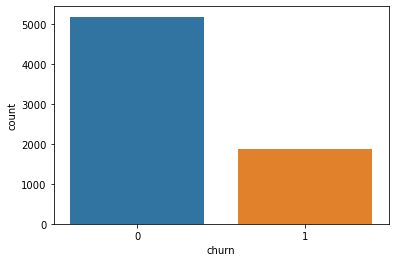

In [47]:
sns.countplot(x='churn', data=df)
plt.show()

Имеется дисбаланс. Запомним

<div class="alert alert-info">
<h3> Комментарий студента:  <a class="tocSkip"> </h3>
Вот тут было чуть чуть про дисбаланс.) 
</div>

посмотрим на целевой признак 

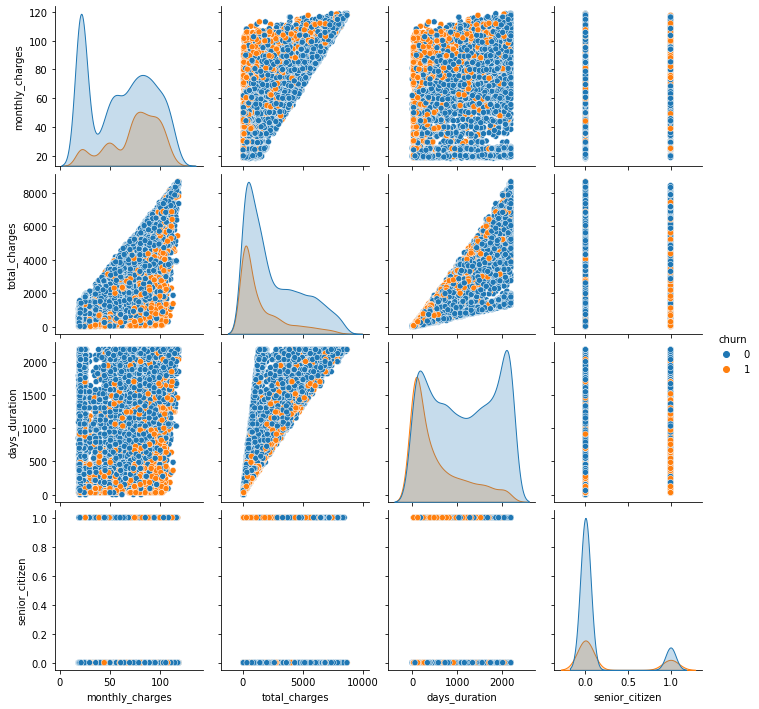

In [48]:
sns.pairplot(df, hue='churn')

Видим что от компании относительно быстро уходят клиенты

распределения признака gender 

In [49]:
df['gender'].loc[df['churn']==1].value_counts()

Female    939
Male      930
Name: gender, dtype: int64

среди ушедших клиентов количество женщин и мужчин практически одинаково.

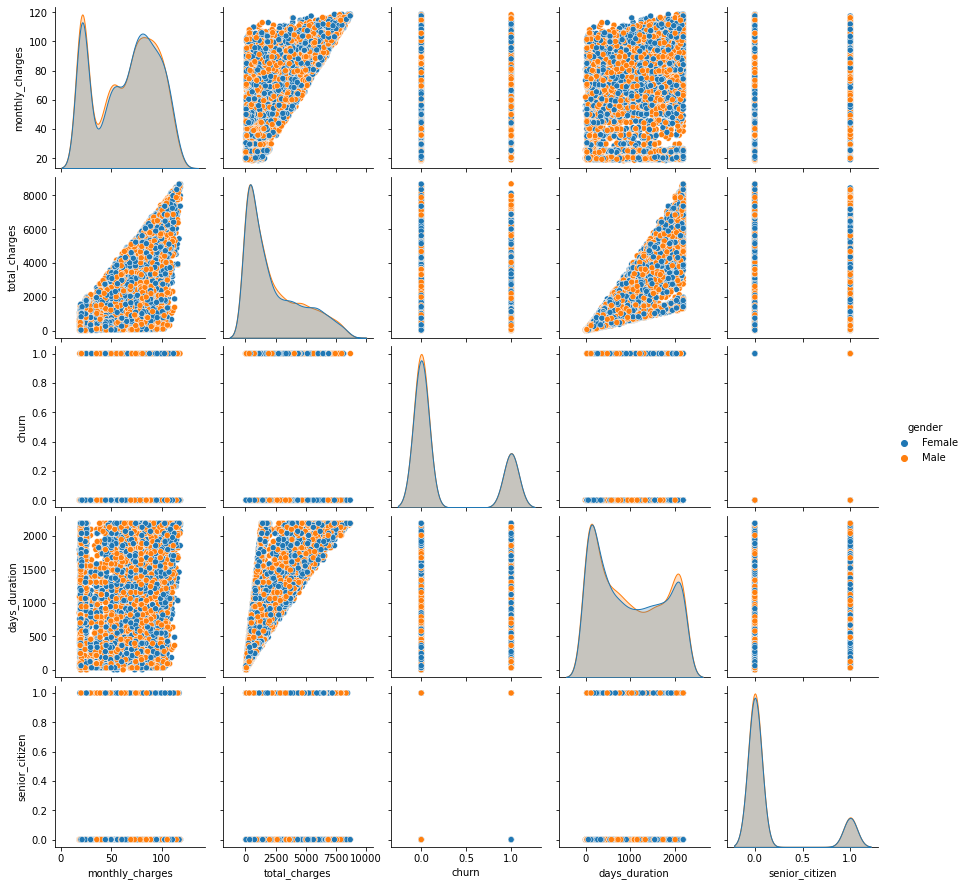

In [50]:
sns.pairplot(df, hue='gender')

Посмотрим на отток клиентов в зависимости от года

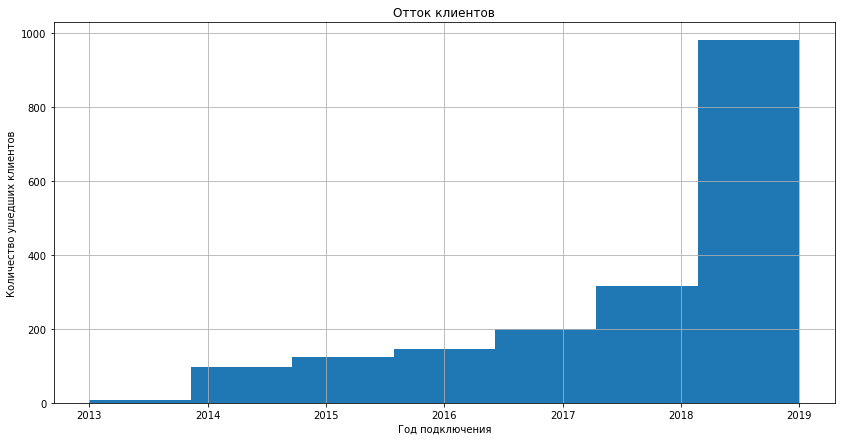

In [51]:
plt.figure(figsize=(14,7))
df.query('churn == 1')['begin_date'].dt.year.plot(kind='hist', bins=7, grid=True)
plt.title('Отток клиентов')
plt.xlabel('Год подключения')
plt.ylabel('Количество ушедших клиентов')
plt.show()

По графику видим, что отток усилился с 2018 по 2019 год.

распределение взаимодействия клиентов с компание по продолжительности в днях

<AxesSubplot:>

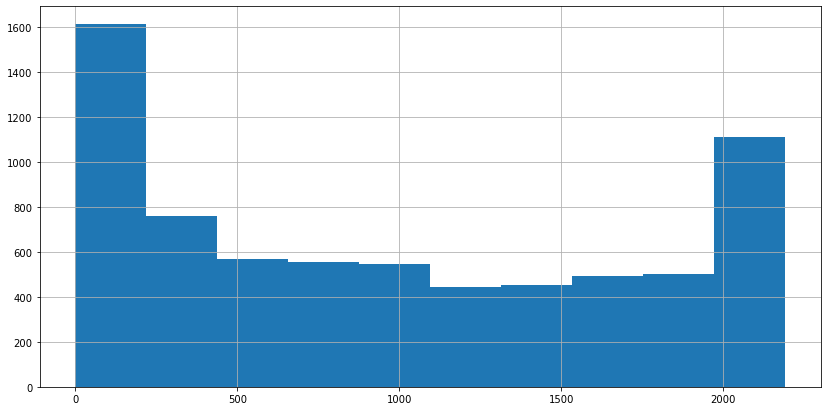

In [52]:
df['days_duration'].hist(figsize=(14,7))

Большинство клиентов если и покидали компанию, то покинули ее в первые месяцы.

Столбцы customer_id, begin_date и end_date удалим. Так как далее они не нужны для обучения\приведут к утечке.

In [53]:
df = df.drop(['customer_id', 'begin_date', 'end_date'], axis=1)

### Корреляция

посмотрим на корреляцию

In [54]:
df.corr()

monthly_charges  total_charges     churn  days_duration  \
monthly_charges         1.000000       0.651182  0.193356       0.247754   
total_charges           0.651182       1.000000 -0.198347       0.826095   
churn                   0.193356      -0.198347  1.000000      -0.352673   
days_duration           0.247754       0.826095 -0.352673       1.000000   
senior_citizen          0.220173       0.102997  0.150889       0.016514   

                 senior_citizen  
monthly_charges        0.220173  
total_charges          0.102997  
churn                  0.150889  
days_duration          0.016514  
senior_citizen         1.000000

In [55]:
df.phik_matrix()

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'churn', 'days_duration', 'senior_citizen']


type  paperless_billing  payment_method  \
type               1.000000           0.106860        0.277462   
paperless_billing  0.106860           1.000000        0.370495   
payment_method     0.277462           0.370495        1.000000   
monthly_charges    0.388444           0.467812        0.399526   
total_charges      0.505287           0.205901        0.350460   
churn              0.251639           0.295754        0.449125   
days_duration      0.664660           0.000000        0.375115   
gender             0.000000           0.000000        0.000000   
senior_citizen     0.086231           0.242133        0.292725   
partner            0.179736           0.013218        0.243008   
dependents         0.147680           0.172593        0.224903   
internet_service   0.505187           0.231438        0.323886   
online_security    0.152145           0.000000        0.262911   
online_backup      0.098884           0.196443        0.282475   
device_protection  0.137610           0.160796        0.306866   
tech_support       0.179999           0.055929        0.272101   
streaming_tv       0.066961           0.343524        0.377209   
streaming_movies   0.069608           0.325551        0.378907   
multiple_lines     0.065498           0.252972        0.339313   

                   monthly_charges  total_charges     churn  days_duration  \
type                      0.388444       0.505287  0.251639       0.664660   
paperless_billing         0.467812       0.205901  0.295754       0.000000   
payment_method            0.399526       0.350460  0.449125       0.375115   
monthly_charges           1.000000       0.762889  0.360050       0.411191   
total_charges             0.762889       1.000000  0.279152       0.842175   
churn                     0.360050       0.279152  1.000000       0.474001   
days_duration             0.411191       0.842175  0.474001       1.000000   
gender                    0.008175       0.000000  0.000000       0.000000   
senior_citizen            0.304985       0.148755  0.233432       0.028663   
partner                   0.203545       0.422402  0.232930       0.491658   
dependents                0.184366       0.114304  0.253936       0.212209   
internet_service          0.919002       0.508171  0.196202       0.019357   
online_security           0.551621       0.544407  0.264580       0.424786   
online_backup             0.629541       0.655082  0.126973       0.465284   
device_protection         0.667481       0.671222  0.101516       0.465931   
tech_support              0.576525       0.565910  0.254615       0.422111   
streaming_tv              0.835340       0.659672  0.096865       0.359254   
streaming_movies          0.833307       0.666350  0.093923       0.371121   
multiple_lines            0.675883       0.605753  0.059581       0.433522   

                     gender  senior_citizen   partner  dependents  \
type               0.000000        0.086231  0.179736    0.147680   
paperless_billing  0.000000        0.242133  0.013218    0.172593   
payment_method     0.000000        0.292725  0.243008    0.224903   
monthly_charges    0.008175        0.304985  0.203545    0.184366   
total_charges      0.000000        0.148755  0.422402    0.114304   
churn              0.000000        0.233432  0.232930    0.253936   
days_duration      0.000000        0.028663  0.491658    0.212209   
gender             1.000000        0.000000  0.000000    0.000000   
senior_citizen     0.000000        1.000000  0.016992    0.324576   
partner            0.000000        0.016992  1.000000    0.652122   
dependents         0.000000        0.324576  0.652122    1.000000   
internet_service   0.000000        0.160702  0.000000    0.108463   
online_security    0.018397        0.057028  0.221673    0.124945   
online_backup      0.009882        0.102065  0.219223    0.031533   
device_protection  0.000000        0.090686  0.238079    0.010416   
tech_support       0.000000        0.

In [56]:
# df.significance_matrix()

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'churn', 'days_duration', 'senior_citizen']


<AxesSubplot:>

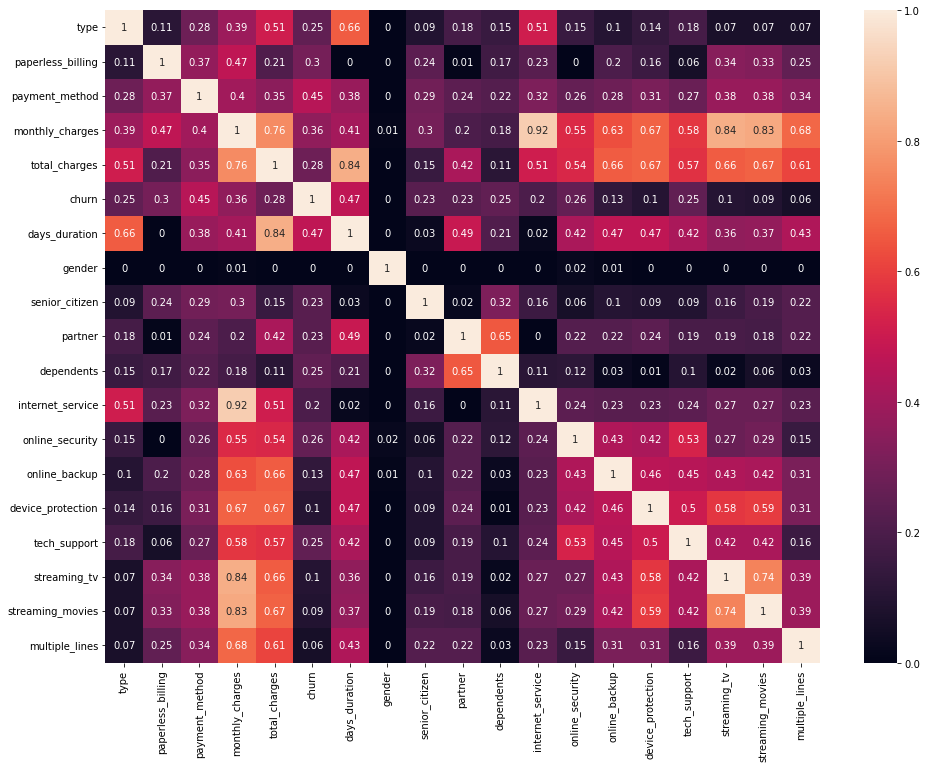

In [57]:
ax,fig = plt.subplots(figsize=(16,12))
sns.heatmap(df.phik_matrix().round(2), annot=True)

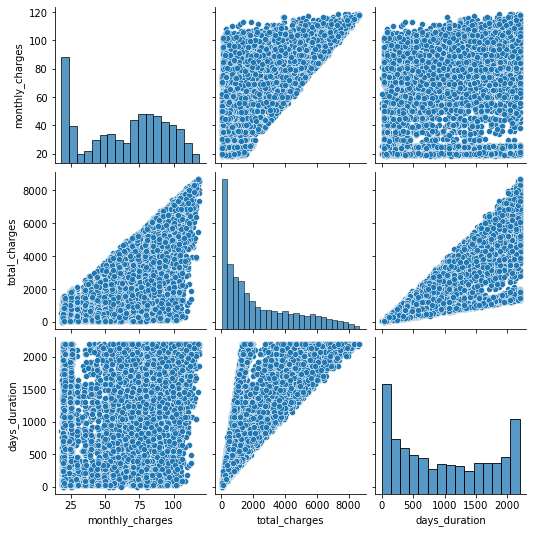

In [58]:
sns.pairplot(df[['monthly_charges', 'total_charges', 'days_duration']])

Имеется высокая корреляция total_charges и времени пользованиями (days_duration) - больше 0.8, удалим total_charges.

In [59]:
df = df.drop('total_charges', axis = 1)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   churn              7043 non-null   int64  
 5   days_duration      7043 non-null   int64  
 6   gender             7043 non-null   object 
 7   senior_citizen     7043 non-null   int64  
 8   partner            7043 non-null   object 
 9   dependents         7043 non-null   object 
 10  internet_service   7043 non-null   object 
 11  online_security    7043 non-null   object 
 12  online_backup      7043 non-null   object 
 13  device_protection  7043 non-null   object 
 14  tech_support       7043 non-null   object 
 15  streaming_tv       7043 non-null   object 
 16  streaming_movies   7043 

In [61]:
df.head()

type paperless_billing             payment_method  \
0  Month-to-month               Yes           Electronic check   
1        One year                No               Mailed check   
2  Month-to-month               Yes               Mailed check   
3        One year                No  Bank transfer (automatic)   
4  Month-to-month               Yes           Electronic check   

   monthly_charges  churn  days_duration  gender  senior_citizen partner  \
0            29.85      0             31  Female               0     Yes   
1            56.95      0           1036    Male               0      No   
2            53.85      1             61    Male               0      No   
3            42.30      0           1371    Male               0      No   
4            70.70      1             61  Female               0      No   

  dependents internet_service online_security online_backup device_protection  \
0         No              DSL              No           Yes                No   
1         No              DSL             Yes            No               Yes   
2         No              DSL             Yes           Yes                No   
3         No              DSL             Yes            No               Yes   
4         No      Fiber optic              No            No                No   

  tech_support streaming_tv streaming_movies multiple_lines  
0           No           No               No             No  
1           No           No               No             No  
2           No           No               No             No  
3          Yes           No               No             No  
4           No           No               No             No

In [62]:
# функция выведения графиков по признакам
def make_plots(df, row):
    fig = px.histogram(df, x=row, color='churn',barmode='group')
    fig.show()

посмотрим на **количественные признаки**

In [63]:
num_features = ['monthly_charges', 'days_duration']
[make_plots(df, row) for row in num_features]

[None, None]

Больше всего уходят клиенты со средним чеком ~ 70-105. Чем больше дюрация сотрудничества тем меньше веротяность ухода клиента.

посмотрим на кактегориальные признаки

In [64]:
cat_features = df.drop(num_features, axis=1)
cat_features = cat_features.drop('churn', axis=1).columns

In [65]:
[make_plots(df, row) for row in cat_features]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Большинство ушедших клиентов 
- выбирали помесячную оплату
- выбирали выставление счёта на электронную почту
- выбирали электронный чек как средство оплаты
- были как женщинами так и мужчинами
- чаще не имели супруга/партнера
- чаще использовали оптоволокно при подключении к интернету
- реже пользовались технической поддержкой


### Выборки

Выделим таргет и признаки:

In [66]:
target = df['churn']
features = df.drop('churn', axis=1)

поделим на выборки 75 на 25

In [67]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                           target,
                                                                           test_size=0.25,
                                                                           random_state=311022,
                                                                           shuffle=True,
                                                                           stratify=target)

In [68]:
features_train.shape, features_test.shape

((5282, 17), (1761, 17))

In [69]:
target_train.shape, target_test.shape

((5282,), (1761,))

In [70]:
df.head()

type paperless_billing             payment_method  \
0  Month-to-month               Yes           Electronic check   
1        One year                No               Mailed check   
2  Month-to-month               Yes               Mailed check   
3        One year                No  Bank transfer (automatic)   
4  Month-to-month               Yes           Electronic check   

   monthly_charges  churn  days_duration  gender  senior_citizen partner  \
0            29.85      0             31  Female               0     Yes   
1            56.95      0           1036    Male               0      No   
2            53.85      1             61    Male               0      No   
3            42.30      0           1371    Male               0      No   
4            70.70      1             61  Female               0      No   

  dependents internet_service online_security online_backup device_protection  \
0         No              DSL              No           Yes                No   
1         No              DSL             Yes            No               Yes   
2         No              DSL             Yes           Yes                No   
3         No              DSL             Yes            No               Yes   
4         No      Fiber optic              No            No                No   

  tech_support streaming_tv streaming_movies multiple_lines  
0           No           No               No             No  
1           No           No               No             No  
2           No           No               No             No  
3          Yes           No               No             No  
4           No           No               No             No

Масштабируем количественные признаки num_features:

In [71]:
scaler = StandardScaler()
scaler.fit(features_train[num_features])

features_train[num_features] = scaler.transform(features_train[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

display(features_train.head())
display(features_test.head())

type paperless_billing             payment_method  \
3040        Two year               Yes    Credit card (automatic)   
20    Month-to-month               Yes           Electronic check   
6457        One year                No    Credit card (automatic)   
1997        Two year               Yes  Bank transfer (automatic)   
5933  Month-to-month               Yes           Electronic check   

      monthly_charges  days_duration  gender  senior_citizen partner  \
3040         1.456984       1.569756    Male               0     Yes   
20          -0.833547      -1.276000    Male               1      No   
6457        -0.674090      -0.624014    Male               0     Yes   
1997         1.358984       1.410768  Female               0     Yes   
5933         1.337391      -1.193165    Male               1      No   

     dependents internet_service online_security online_backup  \
3040         No      Fiber optic              No           Yes   
20           No              DSL              No            No   
6457        Yes              DSL             Yes            No   
1997        Yes      Fiber optic              No            No   
5933         No      Fiber optic              No           Yes   

     device_protection tech_support streaming_tv streaming_movies  \
3040               Yes          Yes          Yes              Yes   
20                 Yes           No           No              Yes   
6457               Yes           No          Yes               No   
1997               Yes          Yes          Yes              Yes   
5933               Yes           No          Yes              Yes   

     multiple_lines  
3040            Yes  
20               No  
6457             No  
1997            Yes  
5933            Yes

type paperless_billing             payment_method  \
85    Month-to-month               Yes    Credit card (automatic)   
6773  Month-to-month               Yes           Electronic check   
1198        Two year               Yes  Bank transfer (automatic)   
825   Month-to-month               Yes    Credit card (automatic)   
6120  Month-to-month                No           Electronic check   

      monthly_charges  days_duration  gender  senior_citizen partner  \
85           1.148036      -0.947335    Male               0      No   
6773         0.922139       0.188295    Male               1     Yes   
1198        -1.461408       0.392709  Female               0      No   
825          0.820817      -0.665431  Female               0     Yes   
6120        -0.175788      -1.070250    Male               0      No   

     dependents internet_service online_security online_backup  \
85           No      Fiber optic              No           Yes   
6773         No      Fiber optic              No            No   
1198         No               No              No            No   
825         Yes      Fiber optic              No           Yes   
6120         No              DSL              No           Yes   

     device_protection tech_support streaming_tv streaming_movies  \
85                  No           No          Yes              Yes   
6773                No           No          Yes              Yes   
1198                No           No           No               No   
825                Yes           No          Yes               No   
6120                No           No          Yes               No   

     multiple_lines  
85              Yes  
6773            Yes  
1198             No  
825              No  
6120             No

Закодируем категориальные признаки с помощью OHE

In [72]:
features_train = pd.get_dummies(features_train, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

In [73]:
features_train 

monthly_charges  days_duration  senior_citizen  type_One year  \
3040         1.456984       1.569756               0              0   
20          -0.833547      -1.276000               1              0   
6457        -0.674090      -0.624014               0              1   
1997         1.358984       1.410768               0              0   
5933         1.337391      -1.193165               1              0   
...               ...            ...             ...            ...   
561         -1.366731      -1.193165               0              0   
4053        -0.149212      -0.865837               1              0   
5342         0.000279       0.186959               0              0   
5978         0.648072       0.555705               0              0   
2903        -0.971411      -0.828428               0              0   

      type_Two year  paperless_billing_Yes  \
3040              1                      1   
20                0                      1   
6457              0                      0   
1997              1                      1   
5933              0                      1   
...             ...                    ...   
561               0                      1   
4053              0                      0   
5342              0                      1   
5978              0                      0   
2903              0                      0   

      payment_method_Credit card (automatic)  payment_method_Electronic check  \
3040                                       1                                0   
20                                         0                                1   
6457                                       1                                0   
1997                                       0                                0   
5933                                       0                                1   
...                                      ...                              ...   
561                                        0                                0   
4053                                       0                                0   
5342                                       0                                1   
5978                                       0                                0   
2903                                       0                                0   

      payment_method_Mailed check  gender_Male  partner_Yes  dependents_Yes  \
3040                            0            1            1               0   
20                              0            1            0               0   
6457                            0            1            1               1   
1997                            0            0            1               1   
5933                            0            1            0               0   
...                           ...          ...          ...             ...   
561                             1            1            1               0   
4053                            0            1            0               0   
5342                            0            0            0               0   
5978                            1            0            0               0   
2903                            1            1            1               1   

      internet_service_Fiber optic  internet_service_No  online_security_Yes  \
3040                             1                    0                    0   
20                               0                    0                    0   
6457                             0                    0                    1   
1997                             1                    0                    0   
5933                             1                    0                    0   
...                            ...                  ...                  ...   
561                              0                    1                    0   
4053                             0    

In [74]:
features_test

monthly_charges  days_duration  senior_citizen  type_One year  \
85           1.148036      -0.947335               0              0   
6773         0.922139       0.188295               1              0   
1198        -1.461408       0.392709               0              0   
825          0.820817      -0.665431               0              0   
6120        -0.175788      -1.070250               0              0   
...               ...            ...             ...            ...   
3323        -1.478018      -0.176442               0              0   
6151         0.207905      -0.951343               0              0   
4299        -0.205686      -0.136361               1              0   
4012        -0.471447      -1.276000               0              0   
6228         0.006923       1.532347               0              1   

      type_Two year  paperless_billing_Yes  \
85                0                      1   
6773              0                      1   
1198              1                      1   
825               0                      1   
6120              0                      0   
...             ...                    ...   
3323              0                      0   
6151              0                      0   
4299              0                      1   
4012              0                      0   
6228              0                      0   

      payment_method_Credit card (automatic)  payment_method_Electronic check  \
85                                         1                                0   
6773                                       0                                1   
1198                                       0                                0   
825                                        1                                0   
6120                                       0                                1   
...                                      ...                              ...   
3323                                       0                                0   
6151                                       0                                1   
4299                                       0                                0   
4012                                       0                                1   
6228                                       0                                0   

      payment_method_Mailed check  gender_Male  partner_Yes  dependents_Yes  \
85                              0            1            0               0   
6773                            0            1            1               0   
1198                            0            0            0               0   
825                             0            0            1               1   
6120                            0            1            0               0   
...                           ...          ...          ...             ...   
3323                            1            0            0               1   
6151                            0            0            0               0   
4299                            0            0            0               0   
4012                            0            0            0               0   
6228                            0            1            0               1   

      internet_service_Fiber optic  internet_service_No  online_security_Yes  \
85                               1                    0                    0   
6773                             1                    0                    0   
1198                             0                    1                    0   
825                              1                    0                    0   
6120                             0                    0                    0   
...                            ...                  ...                  ...   
3323                             0                    1                    0   
6151                             1    

In [75]:
features_train.columns == features_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

порядок и наличие всех колонок в обучающей и тестовой выборке совпадает - кодировка ок. (чтобы избежать дамми-ловушки использовали drop_first=True ранее)

Помним что у нас был дисбаланс, посмотрим на баланс классов целевого признака еще раз после выделения.

0    5174
1    1869
Name: churn, dtype: int64

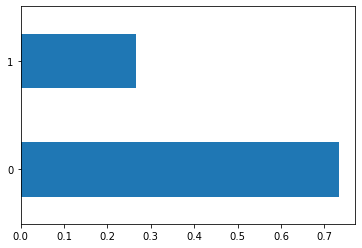

In [76]:
target.value_counts(normalize=True).plot(kind='barh')
target.value_counts()

Видим дисбаланс примерно 1 к 3. Оставим как есть, так как целевая метрика ROC AUC устойчива к дисбалансу классов.

"(Если используется ROC AUC, то перебалансировка и многие другие рецепты не влияют на значение функционала (будет изменение в третьем знаке после запятой))" "дисбаланс – это естественное свойство данных" (с). 

## Модели

Возьмем три модели RandomForestClassifier, LGBMClassifier и CatBoostClassifier. 

### подбор гиперпараметров и обучение

#### RandomForestClassifier

In [77]:
%%time
params = {'max_depth': [3, 7, 9, 12],
                   'class_weight':['balanced', None],
                   'n_estimators': [300, 500, 700],
                   'min_samples_leaf': [2, 4, 6]}

rf = RandomForestClassifier(random_state=311022)

grid_rf = GridSearchCV(rf, params, cv = 3, verbose = 1, n_jobs=-1, scoring = 'roc_auc')
grid_rf.fit(features_train, target_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Wall time: 3min


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=311022),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [3, 7, 9, 12],
                         'min_samples_leaf': [2, 4, 6],
                         'n_estimators': [300, 500, 700]},
             scoring='roc_auc', verbose=1)

In [78]:
grid_rf.best_params_

{'class_weight': None,
 'max_depth': 7,
 'min_samples_leaf': 2,
 'n_estimators': 700}

roc_auc для леса:

In [79]:
grid_rf.best_score_

0.8573799756862961

#### LGBMClassifier

In [80]:
%%time 
lgbm_model = LGBMClassifier(random_state=311022)
params = [{'max_depth':[5, 10],
           'learning_rate':[0.1, 0.05],
           'n_estimators':[800, 900],
           'class_weight':[None,'balanced']}]

lgbm_grid = GridSearchCV(lgbm_model, param_grid=params, scoring='roc_auc', cv=3, verbose=0)
lgbm_grid.fit(features_train, target_train)

Wall time: 48.6 s


GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=311022),
             param_grid=[{'class_weight': [None, 'balanced'],
                          'learning_rate': [0.1, 0.05], 'max_depth': [5, 10],
                          'n_estimators': [800, 900]}],
             scoring='roc_auc')

In [81]:
lgbm_grid.best_params_

{'class_weight': None,
 'learning_rate': 0.05,
 'max_depth': 5,
 'n_estimators': 900}

In [82]:
lgbm_grid.best_score_

0.8930779543660826

#### CatBoostClassifier

In [83]:
%%time 
cat_model = CatBoostClassifier(random_state=311022, verbose=0)

params = {
    'iterations':[100, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'depth': range(6, 11, 2), 
    'l2_leaf_reg': range(3, 10, 2),
    'border_count':[128],
    'loss_function':['Logloss']
}

cat_grid = GridSearchCV(cat_model, params, cv=5, scoring='roc_auc')
cat_grid.fit(features_train, target_train)

Wall time: 46min 16s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000025CAA757700>,
             param_grid={'border_count': [128], 'depth': range(6, 11, 2),
                         'iterations': [100, 1000],
                         'l2_leaf_reg': range(3, 10, 2),
                         'learning_rate': [0.01, 0.1, 0.3],
                         'loss_function': ['Logloss']},
             scoring='roc_auc')

In [84]:
cat_grid.best_params_

{'border_count': 128,
 'depth': 6,
 'iterations': 1000,
 'l2_leaf_reg': 9,
 'learning_rate': 0.1,
 'loss_function': 'Logloss'}

In [85]:
cat_grid.best_score_

0.9081606625296779

По roc_auc лучший результат показала модель CatBoostClassifier

### Тестирование лучшей модели

При тестировании будем использовать CatBoostClassifier с лучшими параметрами cat_grid.best_params_

In [86]:
best_model = CatBoostClassifier(**cat_grid.best_params_, random_state=311022, verbose=0)
best_model.fit(features_train, target_train)
 

In [87]:
predictions_test = best_model.predict(features_test)
probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]


посчитаем roc_auc и accuracy

In [88]:
roc_auc = roc_auc_score(target_test, probabilities_one_test)
accuracy = accuracy_score(target_test, predictions_test)

print('ROC-AUC:', roc_auc)
print('Accuracy:', accuracy)

ROC-AUC: 0.9249062548610123
Accuracy: 0.879045996592845


### Анализ Важности признаков выбранной модели

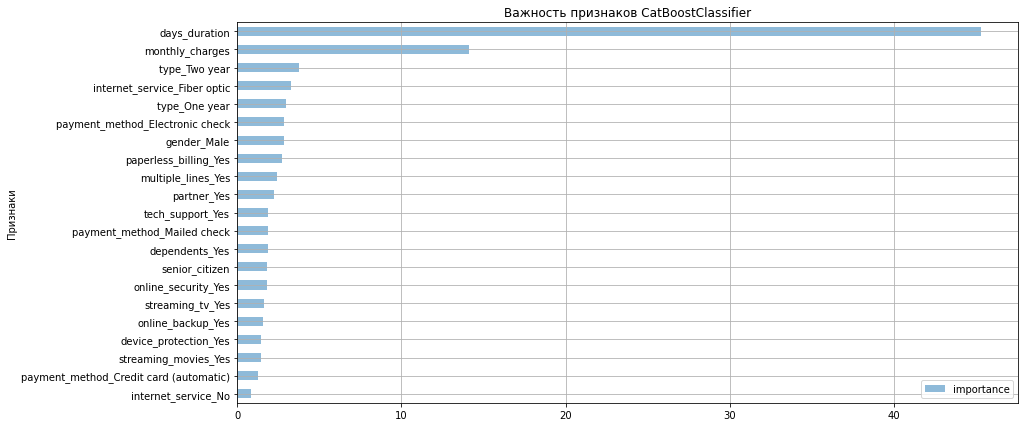

In [89]:
df_feature_importances = pd.DataFrame(best_model.feature_importances_, best_model.feature_names_).rename(columns={0:'importance'}).sort_values(by='importance', ascending = False)
df_feature_importances.plot.barh(alpha = .5, figsize = (14,7), grid = True)
plt.title('Важность признаков CatBoostClassifier')
plt.ylabel('Признаки')
plt.gca().invert_yaxis()
plt.show()

Наиболее важные признаки - days_duration и monthly_charges

## Вывод

В процессе предобработки данных:

- изменили стиль наименования столбцов 
- поменяли типы данных в столбцах total_charges, begin_date и end_date
- заполнили пропуски в total_charges на montly_charges
- добавили столбец с классами для целевого признака и дюрацией

Далее объединили исходные данные, обработали пропуски. Провели исследование и общую подготовку данных. 

Выяснили, что большинство ушедших клиентов

- выбирали помесячную оплату
- выбирали выставление счёта на электронную почту
- выбирали электронный чек как средство оплаты
- были как женщинами так и мужчинами
- чаще не имели супруга/партнера
- чаще использовали оптоволокно при подключении к интернету
- реже пользовались технической поддержкой

Также определили что больше всего уходят клиенты со средним чеком ~ 70-105. Чем больше дюрация сотрудничества тем меньше веротяность ухода клиента.

Далее обработали и подготовили данные для моделей. Применили скалирование для количественных признаков и OHE для категориальных.

Взяли три модели RandomForestClassifier, LGBMClassifier и CatBoostClassifier. Подобрали подобрали гиперпараметры и обучили.

По итогу, наилучший результат показала модель **CatBoostClassifier**. 

Протестировали лучшую модель и расчитали метрики. **ROC-AUC=0.9249 и Accuracy=0.8790**

Наконец, провели анализ важности признаков  для лучшей модели. Наиболее важные признаки - days_duration и monthly_charges

## Отчет по решению

### Какие пункты плана были выполнены, а какие — нет (поясните почему)?

Все пункты первоначального плана были выполнены.

- Загрузка данных и их начальная предобработка (типы, пропуски, дубликаты)
- Объединение/склейка данных
- EDA - Исследовательский анализ данных (посмотреть зависимости, вузализация, выводы)
- Провести подготовку данных к моделированию (исследовать баланс классов, исключение признаков, нормализовать данные)
- Выбор моделей машинного обучения (RandomForestClassifier, LGBMClassifier и CatBoostClassifier)
- Обучение моделей
- Выбрать лучшую модель (CatBoostClassifier)
- Тестирование (ROC-AUC=0.9249 и Accuracy=0.8790)
- Общий вывод/Составление отчета

### Какие трудности возникли и как вы их преодолели?

Первоначально трудности возникли c дополнительными требованиями по структуре и порядком работы, а также с тремя этапами сдачи проекта. Но потом смог адаптироваться и надеюсь сделать все как было указано. Также пару раз возникали сомнения по поводу использования\удаления признаков и борьбой с дисбалансом. Сначала пробовал использовать апсемплинг, но результат был хуже. Поэксперементировав с параметрами и методами пришел к хорошему результату по одной из модели.
Адаптироваться также помог предыдущий опыт в проектах курса, а также очень подробный вебинар и презентация со всеми подробностями о проекте. Особенно спасибо за вебинар, несколько раз пересматривал) По сути весь план, нюансы и даже сам анализ данных проекта были обговорены  в вебинаре оставалось только сделать это все и воплотить на бумаге. 

### Какие ключевые шаги в решении задачи выделили?

- начальная преобработка данных и объединение в одну таблицу
- правильная работа с признаками, выделение целевого признака и дополнительных признаков, дисбаланс
- кросс-валидация и подборгиперпараметров моделей

 

### Какая ваша итоговая модель и какое у неё качество?

По итогу, наилучший результат показала модель **CatBoostClassifier**.

Протестировали лучшую модель со следующими лучшими параметрами:

`cat_grid.best_params_  = {'border_count': 128,
                           'depth': 6,
                           'iterations': 1000,
                           'l2_leaf_reg': 9,
                           'learning_rate': 0.1,
                           'loss_function': 'Logloss'}`

Наиболее важные признаки - days_duration и monthly_charges.

И получили следующие метрики **ROC-AUC=0.9249 и Accuracy=0.8790**. Другими словами с вероятнось 87.9% модель может предсказать уйдет конкретный клиент от компании или нет. Модель полностью справляется с целью и ключевая метрика соответсвует требованиям заказчика (AUC-ROC > 0.88).
